In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [19]:
target = "ABC Valuation"
crcy = "$"                     # Currency symbol
years = 5                      # Projection period: 7 years
iterations = 10000             # Number of simulation iterations
starting_sales = 50          # Starting sales in millions

# Discount and growth assumptions for DCF
wacc = 0.15                    # Discount rate / WACC: 15%
sales_growth_mean = 0.04       # Average annual sales growth: 4%
sales_growth_std = 0.06        # Sales growth standard deviation: 6%
terminal_growth = 0.02         # Terminal (perpetual) growth rate: 2%

# Operating assumptions
ebitda_margin_mean = 0.18      # Average EBITDA margin: 18%
ebitda_margin_std = 0.015      # EBITDA margin standard deviation: 1.5%

capex_percent = 0.04           # Capex as a % of sales: 4%
depr_percent = 0.04            # Depreciation as a % of sales: 4%

nwc_percent_mean = 0.25        # Net Working Capital as a % of sales: 25%
nwc_std = 0.007                # Standard deviation for NWC percentage: 0.7%

tax_rate = 0.30                # Tax rate: 30%
net_debt = -1.2                # Net debt (in millions) – negative means net cash
nb_stock = 2.5                 # Number of shares in millions

In [20]:
def run_dcf_mc(years, iterations, starting_sales,
               sales_growth_mean, sales_growth_std,
               ebitda_margin_mean, ebitda_margin_std,
               capex_percent, depr_percent,
               nwc_percent_mean, nwc_std,
               tax_rate, wacc, terminal_growth):
    """
    Runs a Monte Carlo simulation for a DCF valuation model.
    Returns an array of simulated enterprise values.
    """
    # Generate random arrays for the input variables:
    sales_growth = np.random.normal(sales_growth_mean, sales_growth_std, (years, iterations))
    ebitda_margins = np.random.normal(ebitda_margin_mean, ebitda_margin_std, (years, iterations))
    nwc_percents = np.random.normal(nwc_percent_mean, nwc_std, (years, iterations))

    # Project sales over time
    sales = np.zeros((years, iterations))
    sales[0, :] = starting_sales * (1 + sales_growth[0, :])
    for t in range(1, years):
        sales[t, :] = sales[t-1, :] * (1 + sales_growth[t, :])

    # Calculate EBITDA, depreciation, and EBIT
    ebitda = sales * ebitda_margins
    depreciation = sales * depr_percent
    ebit = ebitda - depreciation

    # Compute taxes only if EBIT is positive
    taxes = np.where(ebit > 0, ebit * tax_rate, 0)

    # Calculate Net Working Capital (NWC) and its change (delta NWC)
    nwc = sales * nwc_percents
    delta_nwc = np.zeros_like(nwc)
    # Assume initial NWC is based on starting sales and mean NWC percentage
    delta_nwc[0, :] = nwc[0, :] - (starting_sales * nwc_percent_mean)
    delta_nwc[1:, :] = nwc[1:, :] - nwc[:-1, :]

    # Capex is treated as an outflow (negative)
    capex = -sales * capex_percent

    # Free Cash Flow: EBIT - Taxes + Depreciation - Capex - Delta NWC
    fcf = ebit - taxes + depreciation - capex - delta_nwc

    # Calculate Terminal Value at the end of the projection period
    terminal_value = fcf[-1, :] * (1 + terminal_growth) / (wacc - terminal_growth)

    # Discount cash flows to present value
    discount_factors = np.array([(1 / (1 + wacc))**(t + 1) for t in range(years)])
    pv_fcf = np.sum(fcf * discount_factors[:, None], axis=0)
    pv_terminal = terminal_value * discount_factors[-1]

    # The enterprise value is the sum of the discounted FCFs and terminal value
    enterprise_values = pv_fcf + pv_terminal
    return enterprise_values

In [21]:
enterprise_vals = run_dcf_mc(years, iterations, starting_sales,
                             sales_growth_mean, sales_growth_std,
                             ebitda_margin_mean, ebitda_margin_std,
                             capex_percent, depr_percent,
                             nwc_percent_mean, nwc_std,
                             tax_rate, wacc, terminal_growth)

In [22]:
# ---- Calculate Summary Statistics ----
mean_val = np.mean(enterprise_vals)
median_val = np.median(enterprise_vals)
std_val = np.std(enterprise_vals)
min_val = np.min(enterprise_vals)
max_val = np.max(enterprise_vals)
perc_5 = np.percentile(enterprise_vals, 5)
perc_95 = np.percentile(enterprise_vals, 95)
lower68 = mean_val - std_val
upper68 = mean_val + std_val
lower95 = mean_val - 2 * std_val
upper95 = mean_val + 2 * std_val

# Calculate equity values (Enterprise Value minus Net Debt)
equity_vals = enterprise_vals - net_debt
mean_equity = np.mean(equity_vals)
median_equity = np.median(equity_vals)
std_equity = np.std(equity_vals)
perc_5_equity = np.percentile(equity_vals, 5)
perc_95_equity = np.percentile(equity_vals, 95)

In [23]:
summary_data = {
    "Metric": ["Mean", "Median", "Std Dev", "Min", "Max", "5th Percentile", "95th Percentile"],
    "Enterprise Value": [mean_val, median_val, std_val, min_val, max_val, perc_5, perc_95],
    "Equity Value": [mean_equity, median_equity, std_equity,
                     np.min(equity_vals), np.max(equity_vals), perc_5_equity, perc_95_equity]
}
summary_df = pd.DataFrame(summary_data)
print("Summary Statistics:")
print(summary_df)

Summary Statistics:
            Metric  Enterprise Value  Equity Value
0             Mean         71.470705     72.670705
1           Median         71.134082     72.334082
2          Std Dev          7.167659      7.167659
3              Min         49.759171     50.959171
4              Max        105.643271    106.843271
5   5th Percentile         60.288410     61.488410
6  95th Percentile         83.778174     84.978174


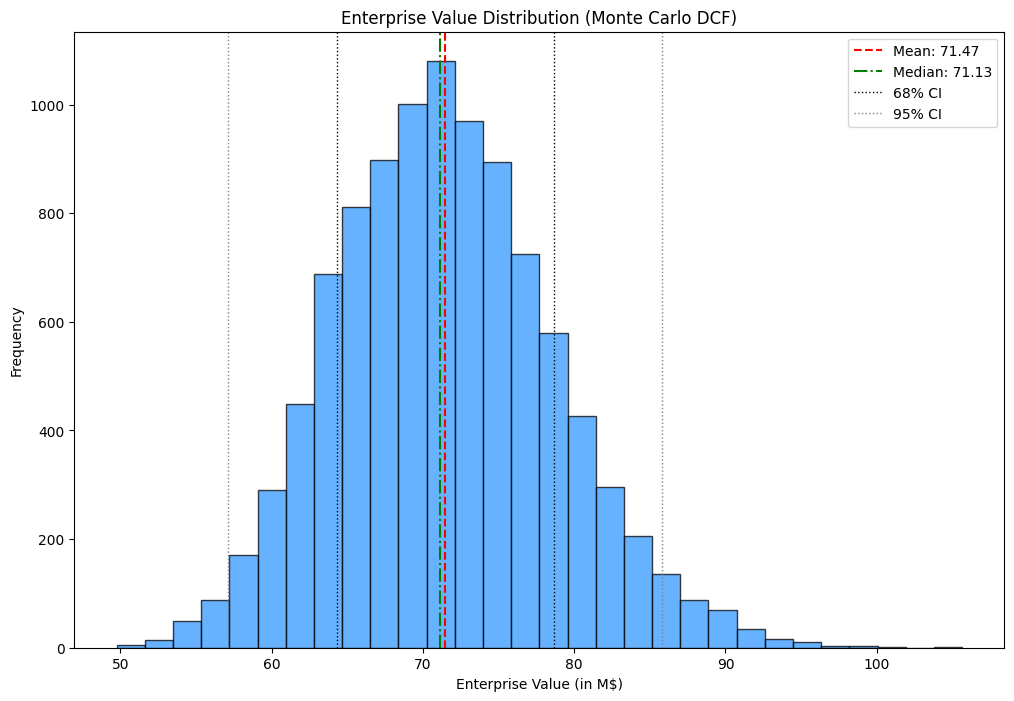

In [24]:
# Histogram of Enterprise Values
plt.figure(figsize=(12, 8))
plt.hist(enterprise_vals, bins=30, color='#3399FF', edgecolor='black', alpha=0.75)
plt.title("Enterprise Value Distribution (Monte Carlo DCF)")
plt.xlabel(f"Enterprise Value (in M{crcy})")
plt.ylabel("Frequency")
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean_val:.2f}")
plt.axvline(median_val, color='green', linestyle='dashdot', linewidth=1.5, label=f"Median: {median_val:.2f}")
plt.axvline(lower68, color='black', linestyle='dotted', linewidth=1, label="68% CI")
plt.axvline(upper68, color='black', linestyle='dotted', linewidth=1)
plt.axvline(lower95, color='gray', linestyle='dotted', linewidth=1, label="95% CI")
plt.axvline(upper95, color='gray', linestyle='dotted', linewidth=1)
plt.legend()
plt.show()

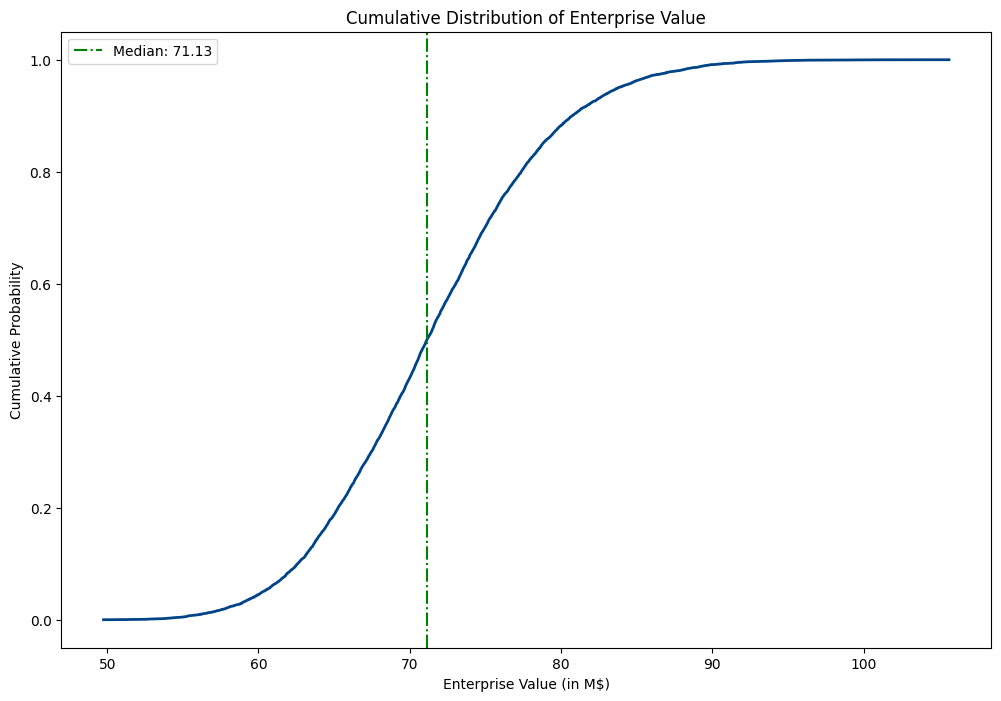

In [25]:
# Cumulative Distribution Function
sorted_vals = np.sort(enterprise_vals)
cdf = np.linspace(0, 1, len(sorted_vals))
plt.figure(figsize=(12, 8))
plt.plot(sorted_vals, cdf, color='#004488', linewidth=2)
plt.title("Cumulative Distribution of Enterprise Value")
plt.xlabel(f"Enterprise Value (in M{crcy})")
plt.ylabel("Cumulative Probability")
plt.axvline(median_val, color='green', linestyle='dashdot', linewidth=1.5, label=f"Median: {median_val:.2f}")
plt.legend()
plt.show()

In [43]:
# Detailed Report
print(f"{target} - Monte Carlo Simulation with {iterations:,d} iterations\n")
print("- Assumptions:")
print(f"Projection Period: {years} years")
print(f"WACC: {wacc*100:.1f}% | Sales Growth: {sales_growth_mean*100:.1f}% (Std: {sales_growth_std*100:.1f}%) | Terminal Growth: {terminal_growth*100:.1f}%")
print(f"Starting Sales: {crcy}{starting_sales}M")
print(f"EBITDA Margin: {ebitda_margin_mean*100:.1f}% (Std: {ebitda_margin_std*100:.1f}%)")
print(f"Capex: {capex_percent*100:.1f}% | Depreciation: {depr_percent*100:.1f}%")
print(f"Net Working Capital: {nwc_percent_mean*100:.1f}% (Std: {nwc_std*100:.1f}%)")
print(f"Tax Rate: {tax_rate*100:.1f}%")
print(f"Net Debt: {crcy}{net_debt}M | Number of Shares: {nb_stock*1e6:,.0f}\n")

print("- Enterprise Value Outcomes:")
print(f"Mean: {crcy}{mean_val:.2f}M")
print(f"Median: {crcy}{median_val:.2f}M")
print(f"Std Dev: {crcy}{std_val:.2f}M")
print(f"Min: {crcy}{min_val:.2f}M, Max: {crcy}{max_val:.2f}M")
print(f"5th Percentile: {crcy}{perc_5:.2f}M, 95th Percentile: {crcy}{perc_95:.2f}M")
print(f"68% Confidence Interval: {crcy}{lower68:.2f}M - {crcy}{upper68:.2f}M")
print(f"95% Confidence Interval: {crcy}{lower95:.2f}M - {crcy}{upper95:.2f}M\n")

print("- Equity Value Outcomes (Enterprise Value - Net Debt):")
print(f"Mean: {crcy}{mean_equity:.2f}M")
print(f"Median: {crcy}{median_equity:.2f}M")
print(f"Std Dev: {crcy}{std_equity:.2f}M")
print(f"5th Percentile: {crcy}{perc_5_equity:.2f}M, 95th Percentile: {crcy}{perc_95_equity:.2f}M")
print(f"Equity Value per Share (Mean): {crcy}{(mean_equity / nb_stock):.2f}")

ABC Valuation - Monte Carlo Simulation with 10,000 iterations

- Assumptions:
Projection Period: 5 years
WACC: 15.0% | Sales Growth: 4.0% (Std: 6.0%) | Terminal Growth: 2.0%
Starting Sales: $50M
EBITDA Margin: 18.0% (Std: 1.5%)
Capex: 4.0% | Depreciation: 4.0%
Net Working Capital: 25.0% (Std: 0.7%)
Tax Rate: 30.0%
Net Debt: $-1.2M | Number of Shares: 2,500,000

- Enterprise Value Outcomes:
Mean: $71.47M
Median: $71.13M
Std Dev: $7.17M
Min: $49.76M, Max: $105.64M
5th Percentile: $60.29M, 95th Percentile: $83.78M
68% Confidence Interval: $64.30M - $78.64M
95% Confidence Interval: $57.14M - $85.81M

- Equity Value Outcomes (Enterprise Value - Net Debt):
Mean: $72.67M
Median: $72.33M
Std Dev: $7.17M
5th Percentile: $61.49M, 95th Percentile: $84.98M
Equity Value per Share (Mean): $29.07
